In [1]:
#import libraries
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#read data
df= pd.read_csv(".\Downloads\Quantium Task 1\QVI_data.csv")

In [3]:
#have a look at the data
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [4]:
# confirm data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [5]:
#check for missing values
df.isnull().sum()

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

## Select Control Stores
The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period.   


Consider the monthly sales experience of each store to get the control store.

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of: 

total sales revenue

total number of customers

average number of transactions per customer

In [6]:
# Convert 'DATE' column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

# Add a new column 'YearMonth' with the format yyyymm
df['YearMonth'] = df['DATE'].dt.strftime('%Y%m')

# Print the DataFrame to check the changes
print(df['YearMonth'].head())

0    201810
1    201809
2    201903
3    201903
4    201811
Name: YearMonth, dtype: object


Next, we define the measure calculations to use during the analysis. For each store and month calculate total sales, number of customers, transactions per customer, chips per customer and the average price per unit.

In [7]:
# Monthly total sales
M_TOT_SALES = df.groupby(["STORE_NBR","YearMonth"])["TOT_SALES"].sum()

# Monthly customer counts
M_CUS_COUNTS = df.groupby(["STORE_NBR","YearMonth"])["LYLTY_CARD_NBR"].nunique()

# Monthly transactions per customer
M_TXN_CUS = df.groupby(["STORE_NBR","YearMonth"])["TXN_ID"].nunique()/M_CUS_COUNTS

# Monthly chips per customer
M_CHIP_CUS = df.groupby(["STORE_NBR","YearMonth"])["PROD_QTY"].sum()/M_CUS_COUNTS

# Monthly average price per unit
M_AVG_PRICE_CHIP = M_TOT_SALES/df.groupby(["STORE_NBR","YearMonth"])["PROD_QTY"].sum()

# Combining metrics together
measureOverTime = pd.concat([M_TOT_SALES, M_CUS_COUNTS, M_TXN_CUS, M_CHIP_CUS, M_AVG_PRICE_CHIP],axis=1)                                 
measureOverTime.columns = ["totSales", "nCustomers", "nTxnPerCust", "nChipsPerTxn", "avgPricePerUnit"]
measureOverTime = measureOverTime.reset_index()
measureOverTime

,STORE_NBR,YearMonth,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947
...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,1.066667,2.022222,4.346154
3165,272,201903,442.3,50,1.060000,2.020000,4.379208
3166,272,201904,445.1,54,1.018519,1.944444,4.239048
3167,272,201905,314.6,34,1.176471,2.088235,4.430986


## Divide the full observation Period
Divide between the Full period and Trial period

In [8]:
# Stores with full observation periods(12 month)
obs_counts = measureOverTime["STORE_NBR"].value_counts()
full_idx = obs_counts[obs_counts == 12].index
storesWithFullObs = measureOverTime[measureOverTime["STORE_NBR"].isin(full_idx)]

# Convert YearMonth to numeric format
storesWithFullObs['YearMonth'] = storesWithFullObs['YearMonth'].astype(int)

# Filter to the pre-trial period (201807 - 201901)
preTrialMeasures = storesWithFullObs[storesWithFullObs['YearMonth'] < 201902]
preTrialMeasures.head(8)


,STORE_NBR,YearMonth,totSales,nCustomers,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,1.061224,1.265306,3.337097
1,1,201808,176.1,42,1.023810,1.285714,3.261111
2,1,201809,278.8,59,1.050847,1.271186,3.717333
3,1,201810,188.1,44,1.022727,1.318182,3.243103
4,1,201811,192.6,46,1.021739,1.239130,3.378947
5,1,201812,189.6,42,1.119048,1.357143,3.326316
6,1,201901,154.8,35,1.028571,1.200000,3.685714
12,2,201807,150.8,39,1.051282,1.179487,3.278261


## Create Functions for Calculations

We need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.

In [9]:
# Create a function to calculate correlation for a measure, looping through each control store

def calculateCorrelation(inputTable, metricCol, storeComparison):
    
    """'inputTable'      as a metric table with potential comparison stores 
       'metricCol'       as the store metric used to calculate correlation on 
       'storeComparison' as the store number of the trial store."""
    
    control_all = inputTable.loc[~inputTable["STORE_NBR"].isin([77,86,88])]
    trial = inputTable.loc[inputTable["STORE_NBR"] == storeComparison][metricCol].reset_index()
    calcCorrTable = pd.DataFrame(columns = ["Control_Store", "Trial_Store", "Corr"])
    
    for i in control_all["STORE_NBR"].unique():
        control = control_all[control_all["STORE_NBR"]==i][metricCol].reset_index()              
        correlation = control.corrwith(trial,axis=0)[1]
        calcCorrTable_i = pd.DataFrame({"Control_Store":i,"Trial_Store":storeComparison,"Corr":[correlation]}) 
        calcCorrTable = pd.concat([calcCorrTable, calcCorrTable_i])
     
    return calcCorrTable

#calculateCorrelation(preTrialMeasures,"totSales",77)

Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store's performance and each control store's performance.

In [10]:
# Create a function to calculate a standardised magnitude distance for a measure, looping through each control store

def calculateMagnitudeDistance(inputTable, metricCol, storeComparison):
    
    """'inputTable'      as a metric table with potential comparison stores 
       'metricCol'       as the store metric used to calculate correlation on 
       'storeComparison' as the store number of the trial store."""
    
    control_all = inputTable.loc[~inputTable["STORE_NBR"].isin([77,86,88])]
    trial = inputTable.loc[inputTable["STORE_NBR"] == storeComparison].reset_index()[metricCol]
    calcDistTable = pd.DataFrame(columns=["Control_Store", "Trial_Store", "Magnitude"])
    
    for i in control_all["STORE_NBR"].unique():
        control = control_all[control_all["STORE_NBR"]==i].reset_index()[metricCol]
        diff = abs(trial - control)
        # Standardise the magnitude distance so that the measure ranges from 0 to 1
        s_diff = np.mean(1-((diff-min(diff))/(max(diff)-min(diff))))
        calcDistTable_i = pd.DataFrame({"Control_Store":i,"Trial_Store":[storeComparison],"Magnitude": s_diff})
        calcDistTable = pd.concat([calcDistTable, calcDistTable_i])
    return calcDistTable

#calculateMagnitudeDistance(preTrialMeasures,"totSales",77)               

let's use the functions to find the control stores! We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

## Select Control Stores
We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores by using correlation and magnitude distance.

### 1) Store 77

In [11]:
# calculate correlations against store 77 using total sales and number of customers
# total sales - corr
corr_nSales_77 = calculateCorrelation(preTrialMeasures,"totSales",77)

# total sales - magnitude distance
magnitude_nSales_77 = calculateMagnitudeDistance(preTrialMeasures,"totSales",77) 

# number of customers - corr
corr_nCustomers_77 = calculateCorrelation(preTrialMeasures,"nCustomers",77)

# number of customers - magnitude distance
magnitude_nCustomers_77 = calculateMagnitudeDistance(preTrialMeasures,"nCustomers",77) 

We'll need to combine the all the scores calculated using our function to create a composite score to rank on.<br>
Let's take a simple average of the correlation and magnitude scores for each driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

In [12]:
# Create a combined score composed of correlation and magnitude
# Merging the correlations table with the magnitude table - Total sales
nSales_77_merge = pd.concat([corr_nSales_77,magnitude_nSales_77["Magnitude"]],axis=1)

# Calculate a combined score - Total sales
corr_weight_a = 0.5
nSales_77_merge["score_nSales"] = corr_weight_a * nSales_77_merge["Corr"] + (1-corr_weight_a) * nSales_77_merge["Magnitude"]


# Merging the correlations table with the magnitude table - number of Customers
nCustomers_77_merge = pd.concat([corr_nCustomers_77,magnitude_nCustomers_77["Magnitude"]],axis=1)

# Calculate a combined score - number of Customers
corr_weight_b = 0.5
nCustomers_77_merge["score_nCustomers"] = corr_weight_b * nCustomers_77_merge["Corr"] + (1-corr_weight_b) * nCustomers_77_merge["Magnitude"]

# Merging the score tables
finalControlScore_77 = pd.concat([nSales_77_merge[["Control_Store", "Trial_Store", "score_nSales"]],nCustomers_77_merge["score_nCustomers"]],axis=1)

# Calculate a final score 
corr_weight_c = 0.5
finalControlScore_77["finalControlScore"] = corr_weight_c * finalControlScore_77["score_nSales"] + (1-corr_weight_c) * finalControlScore_77["score_nCustomers"]
finalControlScore_77

,Control_Store,Trial_Store,score_nSales,score_nCustomers,finalControlScore
0,1,77,0.241691,0.493017,0.367354
0,2,77,0.163520,-0.050311,0.056604
0,3,77,0.664779,0.662002,0.663390
0,4,77,0.190817,0.101310,0.146064
0,5,77,0.202834,0.441632,0.322233
...,...,...,...,...,...
0,268,77,0.387272,0.470473,0.428872
0,269,77,0.121684,0.005090,0.063387
0,270,77,0.453489,0.202710,0.328100
0,271,77,0.348289,0.174100,0.261195


The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [13]:
# Find out the control store with the highest final score
finalControlScore_77.sort_values(by="finalControlScore",ascending=False).head()

,Control_Store,Trial_Store,score_nSales,score_nCustomers,finalControlScore
0,233,77,0.697290,0.816607,0.756949
0,71,77,0.789497,0.663123,0.726310
0,84,77,0.656972,0.715000,0.685986
0,119,77,0.636046,0.729729,0.682887
0,115,77,0.708347,0.645155,0.676751


Now that we have found a control store (the store 233), let's check visually if the drivers are indeed similar in the period before the trial.<br>
We'll look at total sales first.

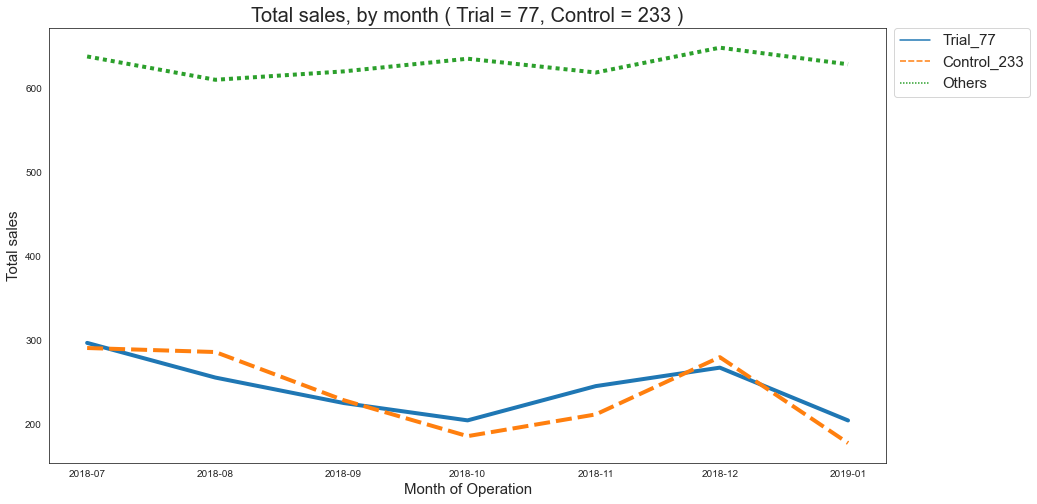

In [14]:
# Visual checks on trends based on the drivers - total sales
a = preTrialMeasures.set_index(["YearMonth","STORE_NBR"])["totSales"].unstack()
others_col = [i for i in a.columns if i not in [77, 233]]
a["others"]=a.loc[:,others_col].mean(axis=1)
paired_77_s = a.loc[:,([77,233,"others"])].reset_index()
paired_77_s["YearMonth"]= pd.to_datetime(paired_77_s["YearMonth"], format="%Y%m")
paired_77_s = paired_77_s.set_index(["YearMonth"])
paired_77_s.columns=["Trial_77","Control_233","Others"]

# Create a lineplot
sns.set_style('white')
plt.figure(figsize=(15,8))
plt.title("Total sales, by month ( Trial = 77, Control = 233 )",fontsize=20)
sns.lineplot(data=paired_77_s, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total sales",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.01,1),borderaxespad = 0.)

number of customers.

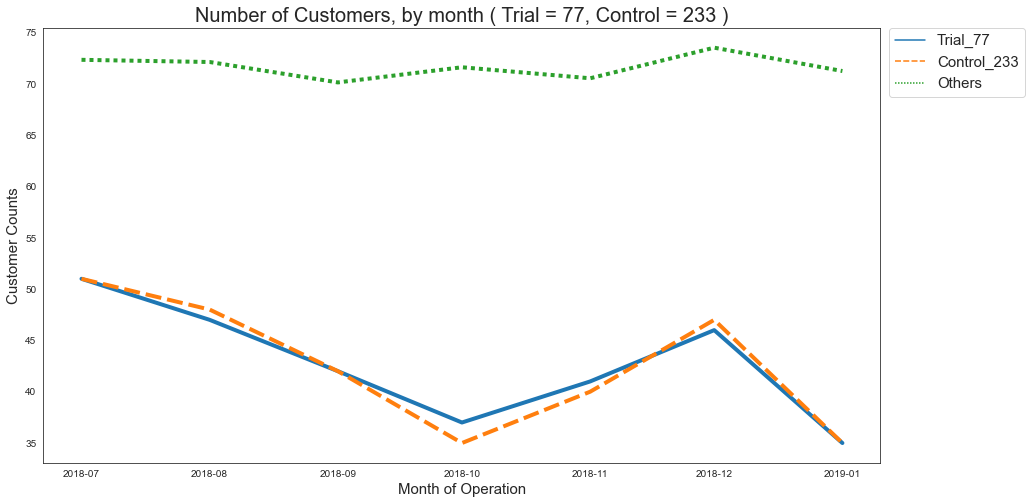

In [15]:
# Visual checks on trends based on the drivers - number of customers
b = preTrialMeasures.set_index(["YearMonth","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [77, 233]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_77_c = b.loc[:,([77,233,"others"])].reset_index()
paired_77_c["YearMonth"]= pd.to_datetime(paired_77_c["YearMonth"], format="%Y%m")
paired_77_c = paired_77_c.set_index(["YearMonth"])
paired_77_c.columns=["Trial_77","Control_233","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 77, Control = 233 )",fontsize=20)
sns.lineplot(data=paired_77_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.01,1),borderaxespad = 0.)

### 2) Store 86

In [16]:
# calculate correlations against store 86 using total sales and number of customers
# total sales - corr
corr_nSales_86 = calculateCorrelation(preTrialMeasures,"totSales",86)

# total sales - magnitude distance
magnitude_nSales_86 = calculateMagnitudeDistance(preTrialMeasures,"totSales",86) 

# number of customers - corr
corr_nCustomers_86 = calculateCorrelation(preTrialMeasures,"nCustomers",86)

# number of customers - magnitude distance
magnitude_nCustomers_86 = calculateMagnitudeDistance(preTrialMeasures,"nCustomers",86) 

In [17]:
# Create a combined score composed of correlation and magnitude
# Merging the correlations table with the magnitude table - Total sales
nSales_86_merge = pd.concat([corr_nSales_86,magnitude_nSales_86["Magnitude"]],axis=1)

# Calculate a combined score - Total sales
corr_weight_a = 0.5
nSales_86_merge["score_nSales"] = corr_weight_a * nSales_86_merge["Corr"] + (1-corr_weight_a) * nSales_86_merge["Magnitude"]
#nSales_86_merge

# Merging the correlations table with the magnitude table - number of Customers
nCustomers_86_merge = pd.concat([corr_nCustomers_86,magnitude_nCustomers_86["Magnitude"]],axis=1)

# Calculate a combined score - number of Customers
corr_weight_b = 0.5
nCustomers_86_merge["score_nCustomers"] = corr_weight_b * nCustomers_86_merge["Corr"] + (1-corr_weight_b) * nCustomers_86_merge["Magnitude"]
#nCustomers_86_merge

# Merging the score tables
finalControlScore_86 = pd.concat([nSales_86_merge[["Control_Store", "Trial_Store", "score_nSales"]],nCustomers_86_merge["score_nCustomers"]],axis=1)

# Calculate a final score 
corr_weight_c = 0.5
finalControlScore_86["finalControlScore"] = corr_weight_c * finalControlScore_86["score_nSales"] + (1-corr_weight_c) * finalControlScore_86["score_nCustomers"]
finalControlScore_86

,Control_Store,Trial_Store,score_nSales,score_nCustomers,finalControlScore
0,1,86,0.466983,0.498018,0.482500
0,2,86,-0.041352,0.171205,0.064927
0,3,86,0.123116,0.104620,0.113868
0,4,86,0.298309,0.184103,0.241206
0,5,86,0.407497,0.230528,0.319013
...,...,...,...,...,...
0,268,86,-0.080126,0.266027,0.092950
0,269,86,0.588661,0.241523,0.415092
0,270,86,-0.106832,-0.058237,-0.082535
0,271,86,0.546651,0.432804,0.489727


In [18]:
# Find out the control store with the highest final score
finalControlScore_86.sort_values(by="finalControlScore",ascending=False).head()

,Control_Store,Trial_Store,score_nSales,score_nCustomers,finalControlScore
0,155,86,0.808106,0.733343,0.770724
0,109,86,0.697120,0.742532,0.719826
0,114,86,0.631393,0.663384,0.647389
0,225,86,0.601841,0.684356,0.643099
0,138,86,0.593296,0.660565,0.626930


155 emereged  on top with the highest score making it the Control store for trial store 86

### Visualization based on Drivers of Sale
1.Total Sales <br>
2.Number of Customers

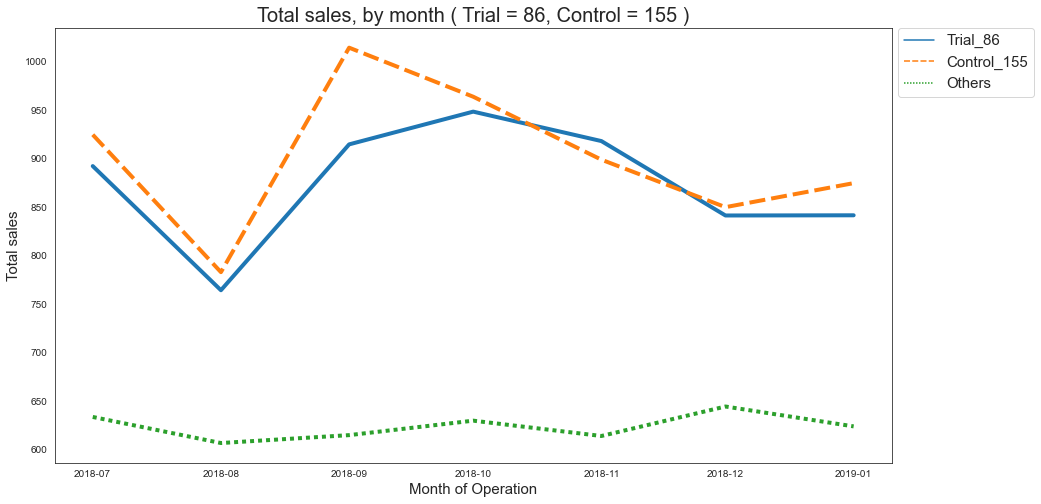

In [19]:
# Visual checks on trends based on the drivers - total sales
a = preTrialMeasures.set_index(["YearMonth","STORE_NBR"])["totSales"].unstack()
others_col = [i for i in a.columns if i not in [86, 155]]
a["others"]=a.loc[:,others_col].mean(axis=1)
paired_86_s = a.loc[:,([86,155,"others"])].reset_index()
paired_86_s["YearMonth"]= pd.to_datetime(paired_86_s["YearMonth"], format="%Y%m")
paired_86_s = paired_86_s.set_index(["YearMonth"])
paired_86_s.columns=["Trial_86","Control_155","Others"]

# Create a lineplot
sns.set_style('white')
plt.figure(figsize=(15,8))
plt.title("Total sales, by month ( Trial = 86, Control = 155 )",fontsize=20)
sns.lineplot(data=paired_86_s, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Total sales",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

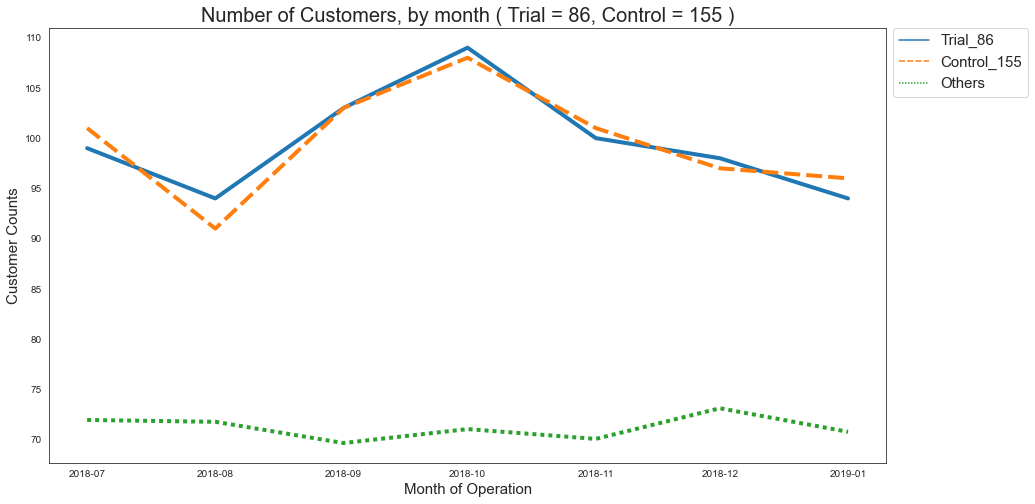

In [20]:
# Visual checks on trends based on the drivers - number of customers
b = preTrialMeasures.set_index(["YearMonth","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [86, 155]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_86_c = b.loc[:,([86,155,"others"])].reset_index()
paired_86_c["YearMonth"]= pd.to_datetime(paired_86_c["YearMonth"], format="%Y%m")
paired_86_c = paired_86_c.set_index(["YearMonth"])
paired_86_c.columns=["Trial_86","Control_155","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 86, Control = 155 )",fontsize=20)
sns.lineplot(data=paired_86_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

### 3) Store 88

In [21]:
# calculate correlations against store 88 using total sales and number of customers
# total sales - corr
corr_nSales_88 = calculateCorrelation(preTrialMeasures,"totSales",88)

# total sales - magnitude distance
magnitude_nSales_88 = calculateMagnitudeDistance(preTrialMeasures,"totSales",88) 

# number of customers - corr
corr_nCustomers_88 = calculateCorrelation(preTrialMeasures,"nCustomers",88)

# number of customers - magnitude distance
magnitude_nCustomers_88 = calculateMagnitudeDistance(preTrialMeasures,"nCustomers",88) 

In [22]:
# Create a combined score composed of correlation and magnitude
# Merging the correlations table with the magnitude table - Total sales
nSales_88_merge = pd.concat([corr_nSales_88,magnitude_nSales_88["Magnitude"]],axis=1)

# Calculate a combined score - Total sales
corr_weight_a = 0.5
nSales_88_merge["score_nSales"] = corr_weight_a * nSales_88_merge["Corr"] + (1-corr_weight_a) * nSales_88_merge["Magnitude"]
#nSales_88_merge

# Merging the correlations table with the magnitude table - number of Customers
nCustomers_88_merge = pd.concat([corr_nCustomers_88,magnitude_nCustomers_88["Magnitude"]],axis=1)

# Calculate a combined score - number of Customers
corr_weight_b = 0.5
nCustomers_88_merge["score_nCustomers"] = corr_weight_b * nCustomers_88_merge["Corr"] + (1-corr_weight_b) * nCustomers_88_merge["Magnitude"]
#nCustomers_88_merge
# Merging the score tables
finalControlScore_88 = pd.concat([nSales_88_merge[["Control_Store", "Trial_Store", "score_nSales"]],nCustomers_88_merge["score_nCustomers"]],axis=1)

# Calculate a final score 
corr_weight_c = 0.5
finalControlScore_88["finalControlScore"] = corr_weight_c * finalControlScore_88["score_nSales"] + (1-corr_weight_c) * finalControlScore_88["score_nCustomers"]
finalControlScore_88


,Control_Store,Trial_Store,score_nSales,score_nCustomers,finalControlScore
0,1,88,0.681297,0.331238,0.506268
0,2,88,0.236643,-0.083332,0.076655
0,3,88,-0.024869,0.603279,0.289205
0,4,88,-0.130559,0.108210,-0.011175
0,5,88,0.343370,0.266561,0.304965
...,...,...,...,...,...
0,268,88,0.250709,0.651462,0.451086
0,269,88,0.196139,0.043061,0.119600
0,270,88,-0.104971,0.132467,0.013748
0,271,88,0.163091,0.318507,0.240799


In [23]:
# Find out the control store with the highest final score
finalControlScore_88.sort_values(by="finalControlScore",ascending=False).head()

,Control_Store,Trial_Store,score_nSales,score_nCustomers,finalControlScore
0,178,88,0.650803,0.707828,0.679316
0,14,88,0.646064,0.685774,0.665919
0,134,88,0.775084,0.540154,0.657619
0,237,88,0.451974,0.777235,0.614604
0,187,88,0.616752,0.594560,0.605656


### Visualization based on Drivers of Sale
1.Total Sales <br>
2.Number of Customers

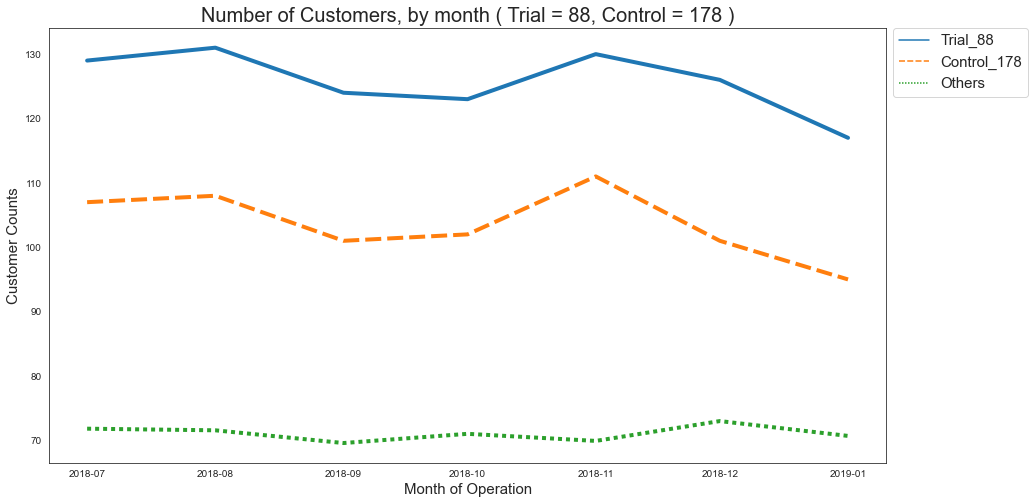

In [24]:
# Visual checks on trends based on the drivers - number of customers
b = preTrialMeasures.set_index(["YearMonth","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [88, 178]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_88_c = b.loc[:,([88,178,"others"])].reset_index()
paired_88_c["YearMonth"]= pd.to_datetime(paired_88_c["YearMonth"], format="%Y%m")
paired_88_c = paired_88_c.set_index(["YearMonth"])
paired_88_c.columns=["Trial_88","Control_178","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 88, Control = 178 )",fontsize=20)
sns.lineplot(data=paired_88_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

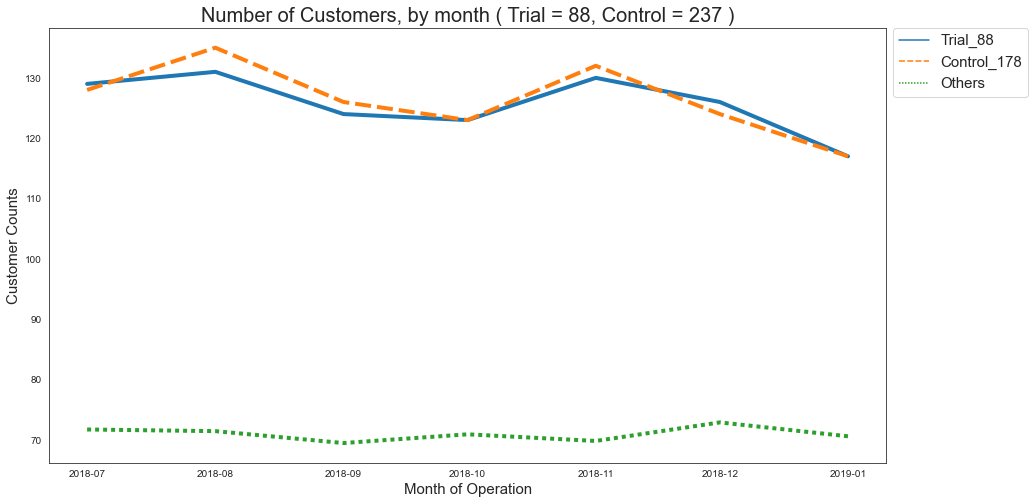

In [25]:
# Visual checks on trends based on the drivers - number of customers
b = preTrialMeasures.set_index(["YearMonth","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [88, 237]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_88_c = b.loc[:,([88,237,"others"])].reset_index()
paired_88_c["YearMonth"]= pd.to_datetime(paired_88_c["YearMonth"], format="%Y%m")
paired_88_c = paired_88_c.set_index(["YearMonth"])
paired_88_c.columns=["Trial_88","Control_178","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 88, Control = 237 )",fontsize=20)
sns.lineplot(data=paired_88_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

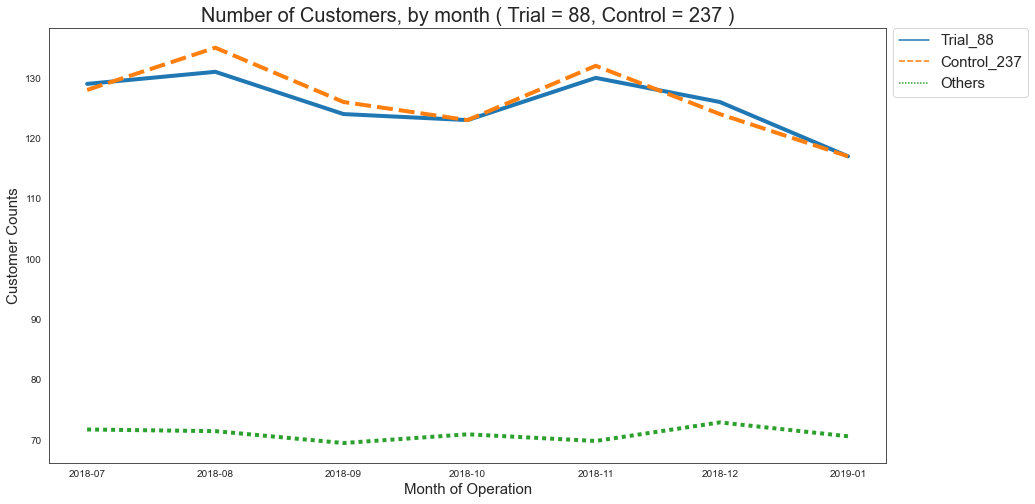

In [26]:
# Visual checks on trends based on the drivers - number of customers
b = preTrialMeasures.set_index(["YearMonth","STORE_NBR"])["nCustomers"].unstack()
others_col = [i for i in b.columns if i not in [88, 237]]
b["others"]=b.loc[:,others_col].mean(axis=1)
paired_88_c = b.loc[:,([88,237,"others"])].reset_index()
paired_88_c["YearMonth"]= pd.to_datetime(paired_88_c["YearMonth"], format="%Y%m")
paired_88_c = paired_88_c.set_index(["YearMonth"])
paired_88_c.columns=["Trial_88","Control_237","Others"]

# Create a lineplot
plt.figure(figsize=(15,8))
plt.title("Number of Customers, by month ( Trial = 88, Control = 237 )",fontsize=20)
sns.lineplot(data=paired_88_c, linewidth=4)
plt.xlabel("Month of Operation",fontsize=15)
plt.ylabel("Customer Counts",fontsize=15)
plt.legend(fontsize=15, bbox_to_anchor=(1.17,1),borderaxespad = 0.)

## Comparison of Trial and Control Pair 

In [27]:
#Ratio of Store 77 and its Control store.
sales_ratio_77 = preTrialMeasures[preTrialMeasures["STORE_NBR"] == 77]["totSales"].sum() / preTrialMeasures[preTrialMeasures["STORE_NBR"] == 233]["totSales"].sum()

#Ratio of Store 86 and its Control store.
sales_ratio_86 = preTrialMeasures[preTrialMeasures["STORE_NBR"] == 86]["totSales"].sum() / preTrialMeasures[preTrialMeasures["STORE_NBR"] == 155]["totSales"].sum()

#Ratio of Store 88 and its Control store.
sales_ratio_88 = preTrialMeasures[preTrialMeasures["STORE_NBR"] == 88]["totSales"].sum() / preTrialMeasures[preTrialMeasures["STORE_NBR"] == 237]["totSales"].sum()

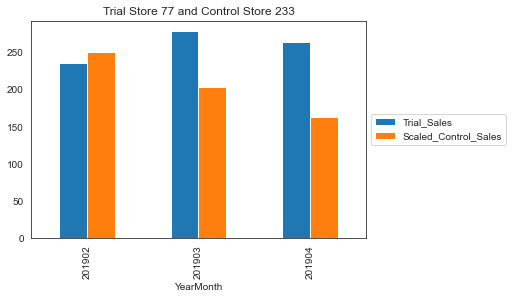

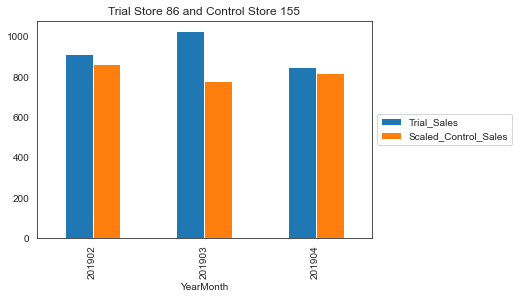

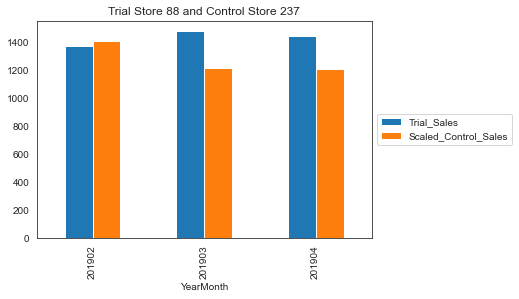

In [28]:
trial_control_dic = {77:233, 86:155, 88:237}
trial_full_observ = storesWithFullObs[(storesWithFullObs["YearMonth"] >= 201902) & (storesWithFullObs["YearMonth"] <= 201904)]
scaled_sales_control_stores = storesWithFullObs[storesWithFullObs["STORE_NBR"].isin([233, 155, 237])][["STORE_NBR", "YearMonth", "totSales"]]

def scaler(row):
    if row["STORE_NBR"] == 233:
        return row["totSales"] * sales_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["totSales"] * sales_ratio_86
    elif row["STORE_NBR"] == 237:
        return row["totSales"] * sales_ratio_88

scaled_sales_control_stores["ScaledSales"] = scaled_sales_control_stores.apply(lambda row: scaler(row), axis=1)

trial_scaled_sales_control_stores = scaled_sales_control_stores[(scaled_sales_control_stores["YearMonth"] >= 201902) & (scaled_sales_control_stores["YearMonth"] <= 201904)]
pretrial_scaled_sales_control_stores = scaled_sales_control_stores[scaled_sales_control_stores["YearMonth"] < 201902]

percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YearMonth", "totSales"]]
    percentage_diff[trial] = b["totSales"].sum() / a["ScaledSales"].sum()
    b[["YearMonth", "totSales"]].merge(a[["YearMonth", "ScaledSales"]],on="YearMonth").set_index("YearMonth").rename(columns={"ScaledSales":"Scaled_Control_Sales", "totSales":"Trial_Sales"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))

In [29]:
percentage_diff

{77: 1.2615468650086281, 86: 1.1315014357363697, 88: 1.121157308767232}

In [30]:
temp1 = scaled_sales_control_stores.sort_values(by=["STORE_NBR", "YearMonth"], ascending=[False, True]).reset_index().drop(["totSales", "index"], axis=1)
temp2 = storesWithFullObs[storesWithFullObs["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YearMonth", "totSales"]].reset_index().drop(["index", "YearMonth"], axis=1)
scaledsales_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledsales_vs_trial.columns = ["c_STORE_NBR", "YearMonth", "c_ScaledSales", "t_STORE_NBR", "t_totSales"]
scaledsales_vs_trial["Sales_Percentage_Diff"] = (scaledsales_vs_trial["t_totSales"] - scaledsales_vs_trial["c_ScaledSales"]) / (((scaledsales_vs_trial["t_totSales"] + scaledsales_vs_trial["c_ScaledSales"])/2))
def label_period(cell):
    if cell < 201902:
        return "pre"
    elif cell > 201904:
        return "post"
    else:
        return "trial"
scaledsales_vs_trial["trial_period"] = scaledsales_vs_trial["YearMonth"].apply(lambda cell: label_period(cell))
scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]

,c_STORE_NBR,YearMonth,c_ScaledSales,t_STORE_NBR,t_totSales,Sales_Percentage_Diff,trial_period
7,237,201902,1406.989143,77,235.0,-1.427524,trial
8,237,201903,1210.082775,77,278.5,-1.251637,trial
9,237,201904,1206.477165,77,263.5,-1.282982,trial
19,233,201902,249.762622,86,913.2,1.140944,trial
20,233,201903,203.802205,86,1026.8,1.337553,trial
21,233,201904,162.345704,86,848.2,1.357394,trial
31,155,201902,864.522060,88,1370.2,0.452565,trial
32,155,201903,780.320405,88,1477.2,0.617385,trial
33,155,201904,819.317024,88,1439.4,0.549058,trial


Check significance of Trial minus Control stores TOT_SALES Percentage Difference Pre-Trial vs Trial.

Step 1: Check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance.

Step 2: Proof control and trial stores are similar statistically

Check p-value of control store's Pre-Trial vs Trial store's Pre-Trial.
If <5%, it is significantly different. If >5%, it is not significantly different (similar).

Step 3: After checking Null Hypothesis of first 2 step to be true, we can check Null Hypothesis of Percentage Difference between Trial and Control stores during pre-trial is the same as during trial.

Check T-Value of Percentage Difference of each Trial month (Feb, March, April 2019).
Mean is mean of Percentage Difference during pre-trial.
Standard deviation is stdev of Percentage Difference during pre-trial.
Formula is Trial month's Percentage Difference minus Mean, divided by Standard deviation.
Compare each T-Value with 95% percentage significance critical t-value of 6 degrees of freedom (7 months of sample - 1)

In [31]:
from scipy.stats import ttest_ind, t

# Step 1
for num in [ 155, 233, 237]:
    print("Store", num)
    print(ttest_ind(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"],
                   equal_var=False), '\n')
    #print(len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"]), len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num]["ScaledSales"]))
    
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=min([len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == num]),
                       len(trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == num])])-1))

Store 155
Ttest_indResult(statistic=1.4291956879290917, pvalue=0.1972705865160342) 

Store 233
Ttest_indResult(statistic=1.1911026010974521, pvalue=0.2944500606486209) 

Store 237
Ttest_indResult(statistic=0.9103825198144718, pvalue=0.4333445481196895) 

Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


Null hypothesis is true. There isn't any statistically significant difference between control store's scaled Pre-Trial and Trial period sales.

In [32]:
a = pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == 237]["ScaledSales"]
b = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == 237]["ScaledSales"]

In [33]:
# Step 2
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    print(ttest_ind(preTrialMeasures[preTrialMeasures["STORE_NBR"] == trial]["totSales"],
                   pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == cont]["ScaledSales"],
                   equal_var=True), '\n')
    #print(len(preTrialMeasures[preTrialMeasures["STORE_NBR"] == trial]["TOT_SALES"]),len(pretrial_scaled_sales_control_stores[pretrial_scaled_sales_control_stores["STORE_NBR"] == cont]["ScaledSales"]))

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(preTrialMeasures[preTrialMeasures["STORE_NBR"] == trial])-1))

Trial store: 77 , Control store: 233
Ttest_indResult(statistic=-1.2533353315065932e-15, pvalue=0.999999999999999) 

Trial store: 86 , Control store: 155
Ttest_indResult(statistic=3.1048311203382156e-15, pvalue=0.9999999999999976) 

Trial store: 88 , Control store: 237
Ttest_indResult(statistic=6.4562888442484815e-15, pvalue=0.999999999999995) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]


Null hypothesis is true. There isn't any statistically significant difference between Trial store's sales and Control store's scaled-sales performance during pre-trial.

In [34]:
# Step 3
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    temp_pre = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == cont) & (scaledsales_vs_trial["trial_period"]=="pre")]
    std = temp_pre["Sales_Percentage_Diff"].std()
    mean = temp_pre["Sales_Percentage_Diff"].mean()
    #print(std, mean)
    for t_month in scaledsales_vs_trial[scaledsales_vs_trial["trial_period"] == "trial"]["YearMonth"].unique():
        pdif = scaledsales_vs_trial[(scaledsales_vs_trial["YearMonth"] == t_month) & (scaledsales_vs_trial["t_STORE_NBR"] == trial)]["Sales_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std)
    print('\n')
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

Trial store: 77 , Control store: 233
201902 : -14.959188942966602
201903 : -13.930934216210712
201904 : -14.11418039587984


Trial store: 86 , Control store: 155
201902 : 10.739683436717112
201903 : 13.680507946090298
201904 : 13.977283515166322


Trial store: 88 , Control store: 237
201902 : 30.343275691926948
201903 : 33.060115159576895
201904 : 31.933833511782304


Critical t-value for 95% confidence interval:
1.9431802803927816


There are 3 months' increase in performance that are statistically significant (Above the 95% confidence interval t-score):

March and April trial months for trial store 77

March trial months for trial store 86

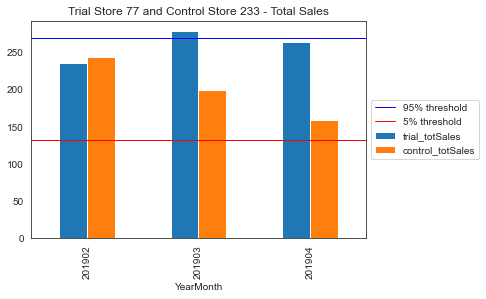

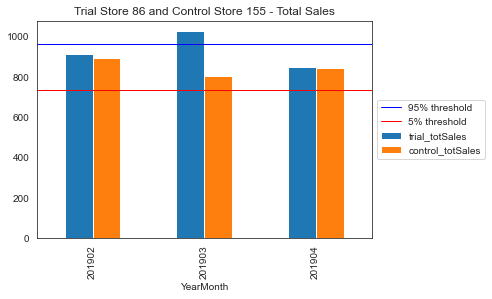

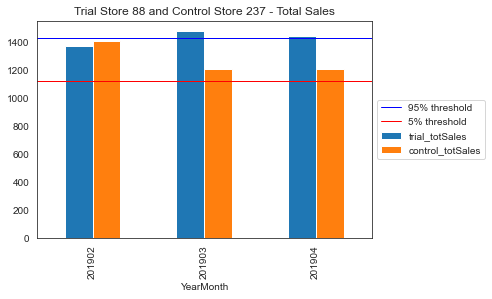

In [35]:
for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control].rename(columns={"totSales": "control_totSales"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YearMonth", "totSales"]].rename(columns={"totSales": "trial_totSales"})
    comb = b[["YearMonth", "trial_totSales"]].merge(a[["YearMonth", "control_totSales"]],on="YearMonth").set_index("YearMonth")
    comb.plot.bar()
    cont_sc_sales = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]["totSales"]
    std = scaledsales_vs_trial[(scaledsales_vs_trial["c_STORE_NBR"] == control) & (scaledsales_vs_trial["trial_period"]=="pre")]["Sales_Percentage_Diff"].std()
    thresh95 = cont_sc_sales.mean() + (cont_sc_sales.mean() * std * 2)
    thresh5 = cont_sc_sales.mean() - (cont_sc_sales.mean() * std * 2)
    plt.axhline(y=thresh95,linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5,linewidth=1, color='r', label="5% threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control)+" - Total Sales")
    plt.savefig("TS {} and CS {} - TOT_SALES.png".format(trial,control), bbox_inches="tight")

In [36]:
#Ratio of Store 77 and its Control store.
ncust_ratio_77 = preTrialMeasures[preTrialMeasures["STORE_NBR"] == 77]["nCustomers"].sum() / preTrialMeasures[preTrialMeasures["STORE_NBR"] == 233]["nCustomers"].sum()

#Ratio of Store 86 and its Control store.
ncust_ratio_86 = preTrialMeasures[preTrialMeasures["STORE_NBR"] == 86]["nCustomers"].sum() / preTrialMeasures[preTrialMeasures["STORE_NBR"] == 155]["nCustomers"].sum()

#Ratio of Store 77 and its Control store.
ncust_ratio_88 = preTrialMeasures[preTrialMeasures["STORE_NBR"] == 88]["nCustomers"].sum() / preTrialMeasures[preTrialMeasures["STORE_NBR"] == 237]["nCustomers"].sum()

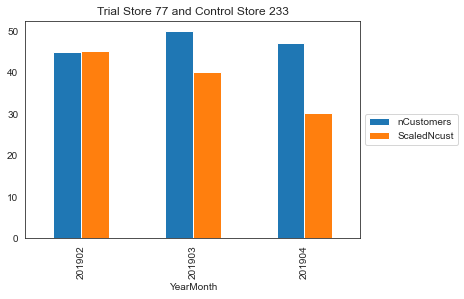

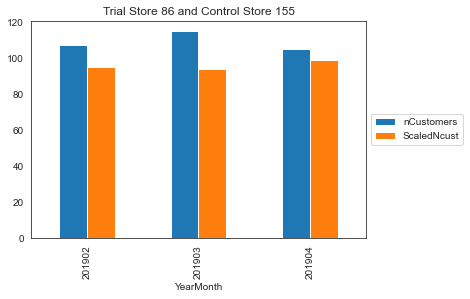

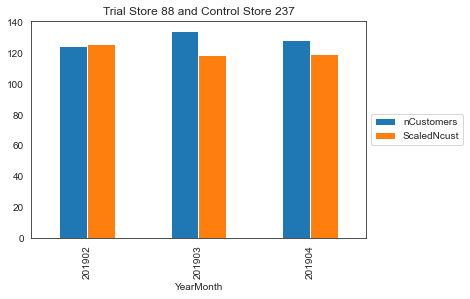

In [37]:
#trial_full_observ = full_observ[(full_observ["YEARMONTH"] >= 201902) & (full_observ["YEARMONTH"] <= 201904)]
scaled_ncust_control_stores = storesWithFullObs[storesWithFullObs["STORE_NBR"].isin([233, 155, 237])][["STORE_NBR", "YearMonth", "nCustomers"]]

def scaler_c(row):
    if row["STORE_NBR"] == 233:
        return row["nCustomers"] * ncust_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["nCustomers"] * ncust_ratio_86
    elif row["STORE_NBR"] == 237:
        return row["nCustomers"] * ncust_ratio_88

scaled_ncust_control_stores["ScaledNcust"] = scaled_ncust_control_stores.apply(lambda row: scaler_c(row), axis=1)

trial_scaled_ncust_control_stores = scaled_ncust_control_stores[(scaled_ncust_control_stores["YearMonth"] >= 201902) & (scaled_ncust_control_stores["YearMonth"] <= 201904)]
pretrial_scaled_ncust_control_stores = scaled_ncust_control_stores[scaled_ncust_control_stores["YearMonth"] < 201902]

ncust_percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YearMonth", "nCustomers"]]
    ncust_percentage_diff[trial] = b["nCustomers"].sum() / a["ScaledNcust"].sum()
    b[["YearMonth", "nCustomers"]].merge(a[["YearMonth", "ScaledNcust"]],on="YearMonth").set_index("YearMonth").rename(columns={"ScaledSales":"Scaled_Control_nCust", "totSales":"Trial_nCust"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))

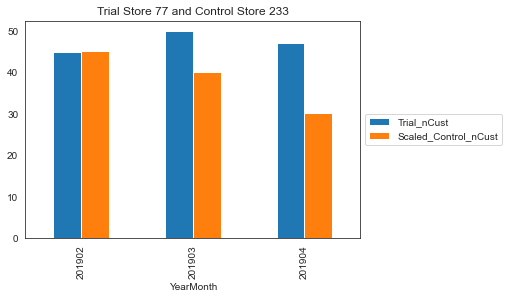

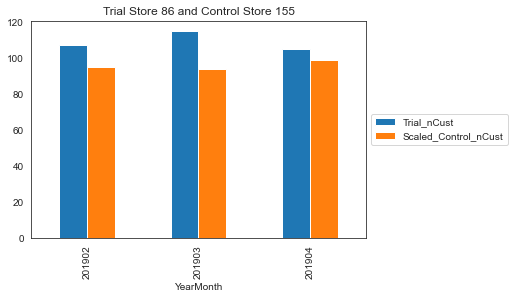

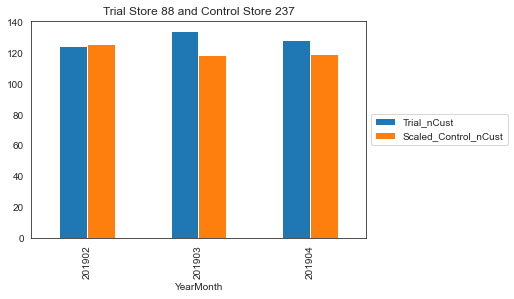

In [38]:
ncust_percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YearMonth", "nCustomers"]]
    
    if not (a.empty or b.empty):  # Check if DataFrames are not empty
        ncust_percentage_diff[trial] = b["nCustomers"].sum() / a["ScaledNcust"].sum()
        b[["YearMonth", "nCustomers"]].merge(a[["YearMonth", "ScaledNcust"]], on="YearMonth").set_index("YearMonth").rename(columns={"ScaledNcust":"Scaled_Control_nCust", "nCustomers":"Trial_nCust"}).plot(kind='bar')
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))
        plt.show()
    else:
        print(f"Data not available for Trial Store {trial} and Control Store {control}")

In [39]:
ncust_percentage_diff

{77: 1.2306529009742622, 86: 1.1354166666666667, 88: 1.0635429638854295}

In [40]:
temp1 = scaled_ncust_control_stores.sort_values(by=["STORE_NBR", "YearMonth"], ascending=[False, True]).reset_index().drop(["nCustomers", "index"], axis=1)
temp2 = storesWithFullObs[storesWithFullObs["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YearMonth", "nCustomers"]].reset_index().drop(["index", "YearMonth"], axis=1)
scaledncust_vs_trial = pd.concat([temp1, temp2], axis=1)
scaledncust_vs_trial.columns = ["c_STORE_NBR", "YearMonth", "c_ScaledNcust", "t_STORE_NBR", "t_nCustomers"]
scaledncust_vs_trial["nCust_Percentage_Diff"] = (scaledncust_vs_trial["t_nCustomers"] - scaledncust_vs_trial["c_ScaledNcust"]) / (((scaledncust_vs_trial["t_nCustomers"] + scaledncust_vs_trial["c_ScaledNcust"])/2))

scaledncust_vs_trial["trial_period"] = scaledncust_vs_trial["YearMonth"].apply(lambda cell: label_period(cell))
scaledncust_vs_trial[scaledncust_vs_trial["trial_period"] == "trial"]

,c_STORE_NBR,YearMonth,c_ScaledNcust,t_STORE_NBR,t_nCustomers,nCust_Percentage_Diff,trial_period
7,237,201902,125.288136,77,45,-0.942968,trial
8,237,201903,118.327684,77,50,-0.811841,trial
9,237,201904,119.322034,77,47,-0.869663,trial
19,233,201902,45.151007,86,107,0.812995,trial
20,233,201903,40.134228,86,115,0.965174,trial
21,233,201904,30.100671,86,105,1.108793,trial
31,155,201902,95.000000,88,124,0.264840,trial
32,155,201903,94.000000,88,134,0.350877,trial
33,155,201904,99.000000,88,128,0.255507,trial


Check significance of Trial minus Control stores nCustomers Percentage Difference Pre-Trial vs Trial.

Step 1: Check null hypothesis of 0 difference between control store's Pre-Trial and Trial period performance.

Step 2: Proof control and trial stores are similar statistically

Step 3: After checking Null Hypothesis of first 2 step to be true, we can check Null Hypothesis of Percentage Difference between Trial and Control stores during pre-trial is the same as during trial.

In [41]:
# Step 1
for num in [155, 233, 237]:
    print("Store", num)
    print(ttest_ind(pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == num]["ScaledNcust"],
                   trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == num]["ScaledNcust"],
                   equal_var=False), '\n')
    
alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=min([len(pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == num]),
                       len(trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == num])])-1))

Store 155
Ttest_indResult(statistic=1.3888888888888882, pvalue=0.204345986327886) 

Store 233
Ttest_indResult(statistic=0.8442563765225701, pvalue=0.4559280037660254) 

Store 237
Ttest_indResult(statistic=1.5160218417872122, pvalue=0.1788106250211205) 

Critical t-value for 95% confidence interval:
[-4.30265273  4.30265273]


In [42]:
# Step 2
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    print(ttest_ind(preTrialMeasures[preTrialMeasures["STORE_NBR"] == trial]["nCustomers"],
                   pretrial_scaled_ncust_control_stores[pretrial_scaled_ncust_control_stores["STORE_NBR"] == cont]["ScaledNcust"],
                   equal_var=True), '\n')

alpha = 0.05
print("Critical t-value for 95% confidence interval:")
print(t.ppf((alpha/2, 1-alpha/2), df=len(preTrialMeasures[preTrialMeasures["STORE_NBR"] == trial])-1))

Trial store: 77 , Control store: 233
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial store: 86 , Control store: 155
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Trial store: 88 , Control store: 237
Ttest_indResult(statistic=0.0, pvalue=1.0) 

Critical t-value for 95% confidence interval:
[-2.44691185  2.44691185]


In [43]:
# Step 3
for trial, cont in trial_control_dic.items():
    print("Trial store:", trial, ", Control store:", cont)
    temp_pre = scaledncust_vs_trial[(scaledncust_vs_trial["c_STORE_NBR"] == cont) & (scaledncust_vs_trial["trial_period"]=="pre")]
    std = temp_pre["nCust_Percentage_Diff"].std()
    mean = temp_pre["nCust_Percentage_Diff"].mean()
    print(std, mean)
    for t_month in scaledncust_vs_trial[scaledncust_vs_trial["trial_period"] == "trial"]["YearMonth"].unique():
        pdif = scaledncust_vs_trial[(scaledncust_vs_trial["YearMonth"] == t_month) & (scaledncust_vs_trial["t_STORE_NBR"] == trial)]["nCust_Percentage_Diff"]
        print(t_month,":",(float(pdif)-mean)/std)
    print('\n')
    
print("Critical t-value for 95% confidence interval:")
conf_intv_95 = t.ppf(0.95, df=len(temp_pre)-1)
print(conf_intv_95)

Trial store: 77 , Control store: 233
0.1462213307771865 0.8018290487428847
201902 : -11.932575703102113
201903 : -11.035806817630123
201904 : -11.431244211809336


Trial store: 86 , Control store: 155
0.07258281710386073 0.23244083047203262
201902 : 7.998505071254294
201903 : 10.09513447008695
201904 : 12.073822028314716


Trial store: 88 , Control store: 237
0.0834927141781641 -0.9887313396296922
201902 : 15.014142666426112
201903 : 16.044615938027523
201904 : 14.902353574278866


Critical t-value for 95% confidence interval:
1.9431802803927816


There are 5 months' increase in performance that are statistically significant (Above the 95% confidence interval t-score):

March and April trial months for trial store 77

Feb, March and April trial months for trial store 86

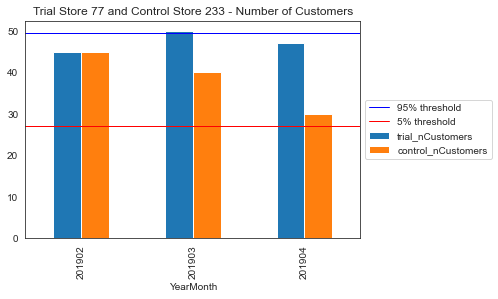

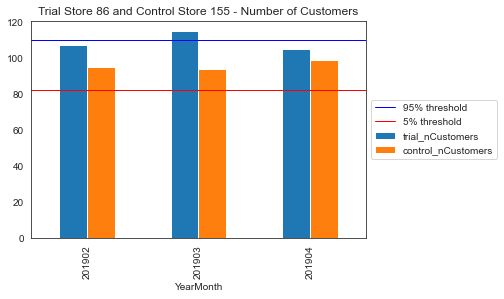

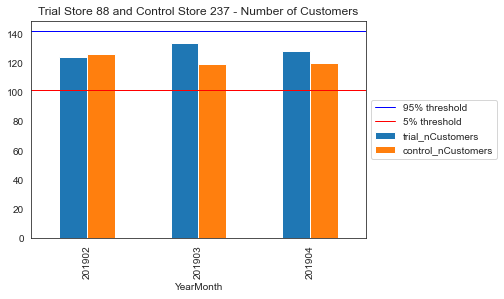

In [44]:
for trial, control in trial_control_dic.items():
    a = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control].rename(columns={"nCustomers": "control_nCustomers"})
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "YearMonth", "nCustomers"]].rename(columns={"nCustomers": "trial_nCustomers"})
    comb = b[["YearMonth", "trial_nCustomers"]].merge(a[["YearMonth", "control_nCustomers"]],on="YearMonth").set_index("YearMonth")
    comb.plot.bar()
    cont_sc_ncust = trial_scaled_ncust_control_stores[trial_scaled_ncust_control_stores["STORE_NBR"] == control]["nCustomers"]
    std = scaledncust_vs_trial[(scaledncust_vs_trial["c_STORE_NBR"] == control) & (scaledncust_vs_trial["trial_period"]=="pre")]["nCust_Percentage_Diff"].std()
    thresh95 = cont_sc_ncust.mean() + (cont_sc_ncust.mean() * std * 2)
    thresh5 = cont_sc_ncust.mean() - (cont_sc_ncust.mean() * std * 2)
    plt.axhline(y=thresh95,linewidth=1, color='b', label="95% threshold")
    plt.axhline(y=thresh5,linewidth=1, color='r', label="5% threshold")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control)+" - Number of Customers")
    plt.savefig("TS {} and CS {} - nCustomers.png".format(trial,control), bbox_inches="tight")

We can see that Trial store 77 sales for Feb, March, and April exceeds 95% threshold of control store. Same goes to store 86 sales for all 3 trial months.

1. Trial store 77: Control store 233
2. Trial store 86: Control store 155
3. Trial store 88: Control store 40
4. Both trial store 77 and 86 showed significant increase in Total Sales and Number of Customers during trial period. But not for trial store 88. Perhaps the client knows if there's anything about trial 88 that differs it from the other two trial.
5. Overall the trial showed positive significant result.